<a href="https://colab.research.google.com/github/EHDEV/xitext_model_trainer/blob/main/trainer_nb-onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers install onnxruntime onnxruntime-tools 

     |████████████████████████████████| 1.5MB 15.8MB/s 
     |████████████████████████████████| 4.1MB 51.1MB/s 
     |████████████████████████████████| 174kB 52.8MB/s 
     |████████████████████████████████| 890kB 59.0MB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 7.7MB 21.6MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2ebc964589e225d9a29fa383e15a132bce2e6509655c64bdcc946f2d7ddff7c6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=d3b661e91c2fd069ac4e889ef25727ebe866a4cc7dd9d49379fe8374aba1917a
  Stored in direc

### Download repo and set working directory
- Get the latest trainer code from github
- set working directory then execute code

In [7]:
%%shell

export HOME=/content/drive/MyDrive/xitext
export GH_REPO=xitext_model_trainer
cd $HOME
git clone  https://github.com/EHDEV/${GH_REPO}.git  || (cd $GH_REPO; git pull)


fatal: destination path 'xitext_model_trainer' already exists and is not an empty directory.
Already up to date.


In [21]:
cd /content/drive/MyDrive/xitext/xitext_model_trainer/

/content/drive/MyDrive/xitext/xitext_model_trainer


#### Import classes and required functions

In [22]:
from file_config import FileConfig
from models import SequenceClassifierModel
from convert_optimize_onnx import TorchToONNX
from data_preprocess import TextClassifierData, _encode_text_into_tokens
from pathlib import Path
import torch

#### Set data file path and other configurations of the file

In [23]:
fconfig = FileConfig(
    path_to_directory=Path('/content/drive/MyDrive/datasets/'), 
    target_column='topic',
    sequence_column='text',
    delimiter=',')


In [24]:
text_clas_data = TextClassifierData(fconfig)
train_data, val_data = text_clas_data.preprocess()

DEBUG:data-preprocessing.log:load data started
DEBUG:data-preprocessing.log:dataframe with shape (200853, 2) has been created
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
DEBUG:data-preprocessing.log:sentence column cleaned
DEBUG:data-preprocessing.log:Clean_label_column complete
DEBUG:data-preprocessing.log:Underrepresented classes have been removed and data condensed
DEBUG:data-preprocessing.log:preparing data for training: train/val split and convert to tensor
DEBUG:data-preprocessing.log:train test split completed
DEBUG:data-preprocessing.log:Tokenizing train and valid data
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139620782640152 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f69309

DEBUG:filelock:Attempting to release lock 139620782640152 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
INFO:filelock:Lock 139620782640152 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139619492086168 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
INFO:filelock:Lock 139619492086168 acquired on /root/.cache/huggingface/transformers/534479488c54aeaf9c3

DEBUG:filelock:Attempting to release lock 139619492086168 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
INFO:filelock:Lock 139619492086168 released on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


DEBUG:data-preprocessing.log:Encoding input sentences completed
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:data-preprocessing.log:Encoding input sentences completed
DEBUG:data-preprocessing.log:Wrapping tensors in dataloader completed
DEBUG:data-preprocessing.log:Wrapping tensors in dataloader completed
DEBUG:data-preprocessing.log:data preparation for training is complete. 2385 train and 597 validation examples
DEBUG:data-preprocessing.log:Data preprocessing complete


#### Write classes and their indices as a json in model directory

In [28]:
import json
with open(torch_model_dir) as cfile:
    cfile.write(json.dumps(
        { k: v for k,v in enumerate(text_clas_data.classes) }
    ))


{0: 'arts',
 1: 'arts & culture',
 2: 'black voices',
 3: 'business',
 4: 'college',
 5: 'comedy',
 6: 'crime',
 7: 'culture & arts',
 8: 'divorce',
 9: 'education',
 10: 'entertainment',
 11: 'environment',
 12: 'fifty',
 13: 'food & drink',
 14: 'good news',
 15: 'green',
 16: 'healthy living',
 17: 'home & living',
 18: 'impact',
 19: 'latino voices',
 20: 'media',
 21: 'money',
 22: 'parenting',
 23: 'parents',
 24: 'politics',
 25: 'queer voices',
 26: 'religion',
 27: 'science',
 28: 'sports',
 29: 'style',
 30: 'style & beauty',
 31: 'taste',
 32: 'tech',
 33: 'the worldpost',
 34: 'travel',
 35: 'weddings',
 36: 'weird news',
 37: 'wellness',
 38: 'women',
 39: 'world news',
 40: 'worldpost'}

In [29]:
import os
if not os.path.isdir('./data'):
  os.mkdir('./data')

torch.save(train_data, './data/topic-train.pth')
torch.save(val_data, './data/topic-valid.pth')

In [31]:
train_data = torch.load('./data/topic-train.pth')
val_data = torch.load('./data/topic-valid.pth')

In [33]:
seq_model = SequenceClassifierModel(
    this_project_name='news-topic-classifier', 
    model_group='distilbert',
    optimizer='adam',
    scheduler='linear',
    num_labels=text_clas_data.num_labels,
    epochs=4,
    train_data=train_data,
    val_data=val_data
)

seq_model.train()


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139619050919472 on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
INFO:filelock:Lock 139619050919472 acquired on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /distilbert-base-uncased/resolve/main/config.json HTTP/1.1" 200 442


DEBUG:filelock:Attempting to release lock 139619050919472 on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
INFO:filelock:Lock 139619050919472 released on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139619501610992 on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock
INFO:filelock:Lock 139619501610992 acquired on /root/.cache/huggingface/transformers/9c169103d7

DEBUG:filelock:Attempting to release lock 139619501610992 on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock
INFO:filelock:Lock 139619501610992 released on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

=============== Epoch 1 / 4 ======
Training...
Batch    40 of 2,385. Elapsed: 0:00:12.
Batch    80 of 2,385. Elapsed: 0:00:24.
Batch   120 of 2,385. Elapsed: 0:00:36.
Batch   160 of 2,385. Elapsed: 0:00:48.
Batch   200 of 2,385. Elapsed: 0:01:00.
Batch   240 of 2,385. Elapsed: 0:01:12.
Batch   280 of 2,385. Elapsed: 0:01:25.
Batch   320 of 2,385. Elapsed: 0:01:37.
Batch   360 of 2,385. Elapsed: 0:01:50.
Batch   400 of 2,385. Elapsed: 0:02:03.
Batch   440 of 2,385. Elapsed: 0:02:15.
Batch   480 of 2,385. Elapsed: 0:02:28.
Batch   520 of 2,385. Elapsed: 0:02:41.
Batch   560 of 2,385. Elapsed: 0:02:54.
Batch   600 of 2,385. Elapsed: 0:03:07.
Batch   640 of 2,385. Elapsed: 0:03:20.
Batch   680 of 2,385. Elapsed: 0:03:33.
Batch   720 of 2,385. Elapsed: 0:03:46.
Batch   760 of 2,385. Elapsed: 0:03:59.
Batch   800 of 2,385. Elapsed: 0:04:12.
Batch   840 of 2,385. Elapsed: 0:04:25.
Batch   880 of 2,385. Elapsed: 0:04:38.
Batch   920 of 2,385. Elapsed: 0:04:51.
Batch   960 of 2,385. Elapsed: 0:

In [34]:


torch_model_path = ''
onnx_model_dir = ''

tto = TorchToONNX(
    torch_model_path=,
    onnx_model_dir=omp,
    tokenizer= text_clas_data.tokenizer
)

SyntaxError: ignored

In [ ]:
text_clas_data.data_df.head()

,text,topic
0,there were 2 mass shootings in texas last week...,crime
1,will smith joins diplo and nicky jam for the 2...,entertainment
2,hugh grant marries for the first time at age 57,entertainment
3,jim carrey blasts 'castrato' adam schiff and d...,entertainment
4,julianna margulies uses donald trump poop bags...,entertainment


In [ ]:
from scipy.special import softmax
def make_predictions(model, encoded_sentence, attention_mask, token_type_id=None):
    
    model.eval()
    with torch.no_grad():
        
        preds = model(
                    encoded_sentence,
                    attention_mask=attention_mask
                ) 
            # labels are not passed here in validation
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like softmax
        
        logits = preds[0]
        probabilities = torch.nn.functional.softmax(logits, dim=1)        
        probabilities = probabilities.detach().cpu().numpy()
        # Move logits and labels to CPU

        np.set_printoptions(suppress=True)

    return probabilities[-1].round(4)


In [ ]:
import numpy as np
sentence = [
	'The KKK used to run a youth group called the Klu Klux Kiddies. A sobering reminder of how evil shit like this starts at home.']

encoded_tensor = _encode_text_into_tokens( sentence, text_clas_data.tokenizer)

# print(encoded_tensor.shape, attention_mask_tensor.shape)

seq_model.model.eval()
seq_model.model.to('cpu')
prediction_probabilities = make_predictions(
    model=seq_model.model,
    encoded_sentence=encoded_tensor['input_ids'], 
    attention_mask=encoded_tensor['attention_mask']
)

from collections import OrderedDict
top_topics = OrderedDict()
classes=text_clas_data.classes
for i in prediction_probabilities.argsort()[-10:][::-1]:
    top_topics[classes[i]] = prediction_probabilities[i]

top_topics

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:data-preprocessing.log:Encoding input sentences completed


OrderedDict([('politics', 0.6277),
             ('black voices', 0.0898),
             ('queer voices', 0.0752),
             ('crime', 0.0716),
             ('entertainment', 0.0501),
             ('comedy', 0.0192),
             ('religion', 0.0159),
             ('weird news', 0.0086),
             ('business', 0.0062),
             ('impact', 0.005)])

In [ ]:
prediction_probabilities

array([0.0008, 0.0031, 0.0898, 0.0062, 0.0009, 0.0192, 0.0716, 0.0003,
       0.0003, 0.0002, 0.0501, 0.0003, 0.0003, 0.0009, 0.0012, 0.001 ,
       0.0019, 0.0002, 0.005 , 0.0045, 0.0016, 0.0002, 0.0004, 0.0003,
       0.6277, 0.0752, 0.0159, 0.0003, 0.0008, 0.0001, 0.0001, 0.0011,
       0.0017, 0.0004, 0.0009, 0.0001, 0.0086, 0.0008, 0.0026, 0.0006,
       0.0029], dtype=float32)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

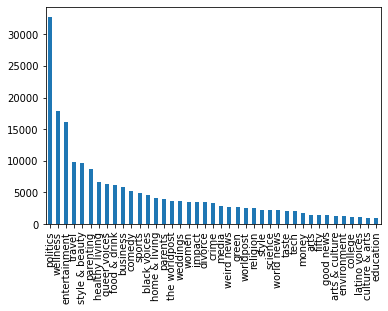

In [ ]:
??text_clas_data.data_df['topic'].value_counts().plot(kind='bar', size=(10,12))